Iterative Closest point:

Importing all the necessary libraries.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Read the image:

In [3]:
image = cv2.imread('data/hand.jpg', 0)

Define a Class ICP that takes an image and a set of landmark points as initial parameters:

In [4]:
class ICP:
    def __init__(self, image, landmarks):
        self.image = image
        self.landmarks = landmarks
        self.psi = None
        self.iterations = 0
        self.x = None

    def get_pixel_locations(self):
        '''
        map landmarks to pixel co-ordinates
        :return: pixel co-ordinates
        '''
        W = self.landmarks.T
        return W[0], W[1]

    def get_distance_transformed(self):
        '''
        Calculate the distance transformation of the image
        :return: distance transformation of the image
        '''
        edges = cv2.Canny(self.image, 40, 80)
        edges[np.where(edges == 255)] = 1.0
        edges[np.where(edges == 0)] = 255.0
        edges[np.where(edges == 1)] = 0.0
        distance_transformed = cv2.distanceTransform(edges, cv2.DIST_L2, 3).astype(np.uint8)
        return distance_transformed.astype(np.float32)

    def get_transformation(self, landmarks, image_points):
        '''
        Try to find an affine transformation matrix that maps landmarks to the image_points
        :param landmarks: initial guess of the shape
        :param image_points: corresponding points on the image
        :return:
        '''
        dim = landmarks.shape[0]
        I = np.vstack([np.diag([1., 1.])]*dim)
        xn = np.column_stack([image_points.T[1], image_points.T[0]]).flatten()
        first = np.zeros((landmarks.shape[0]*2, landmarks.shape[1]))
        first[::2] = np.fliplr(landmarks)
        second = np.vstack([[0., 0.], first])[:-1]
        points = np.hstack([first, second, I])
        psi = np.dot(np.linalg.pinv(points), xn)
        correspondence = np.reshape(points @ psi, (int(xn.shape[0] / 2), 2))
        new_landmarks = np.column_stack([correspondence.T[1], correspondence.T[0]]).astype(int)
        return psi, new_landmarks

    def plot_landmarks(self, landmarks, title, x=None):
        '''
        Plot the landmarks on the image
        :param landmarks: approximation of the points on the shape
        :param title: Title of the plot
        :param x: Image points if available
        :return:
        '''
        plt.figure()
        plt.imshow(image, cmap=plt.cm.gray)
        if x is not None:
            plt.scatter(x[:, 1], x[:, 0], c='r', s=10)
        plt.scatter(landmarks[:, 1], landmarks[:, 0], c='y', s=10)
        plt.grid()
        plt.title(title)
        plt.show()

    def run_ICP(self, generate_plot=True):
        '''
        Try to map the W to the closest point on the edge of the shape
        :param generate_plot: Boolean flag for plotting
        :return: the final landmark points closest to the shape
        '''
        D = self.get_distance_transformed()
        G_y, G_x = np.gradient(D)
        delta = False
        wn_old = self.landmarks
        while not delta:
            X, Y = self.get_pixel_locations()
            Gx = G_x[X, Y]
            Gy = G_y[X, Y]
            gradient = np.column_stack([Gy, Gx])
            Dn = D[X, Y]
            denominator = np.hypot(Gy, Gx).reshape(-1, 1)
            numerator = Dn.reshape(-1, 1) * gradient
            xn_new = self.landmarks - np.divide(numerator, denominator, where=denominator != 0)
            psi, wn_new = self.get_transformation(self.landmarks, xn_new.astype('int'))
            if generate_plot:
                self.plot_landmarks(wn_new.astype('int'), 'Iteration: {}'.format(self.iterations+1), xn_new.astype('int'))
            self.iterations += 1
            self.landmarks = wn_new.astype('int')
            delta = np.array_equal(psi, self.psi)
            self.psi = psi
            self.x = xn_new.astype('int')
        return self.landmarks

Now the main function. First read the landmarks and process them as per requirement. Then initialise an instance of ICP and run the algorithm on the set of landmarks provided. We used generate_plot flag to generate the plots in each iterations.

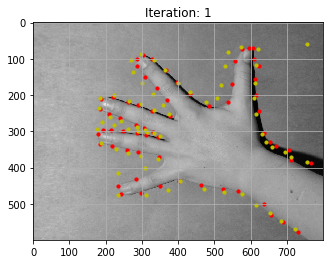

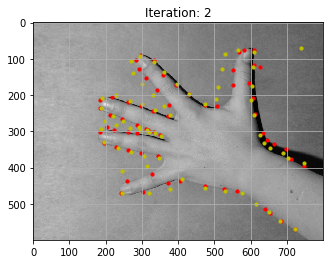

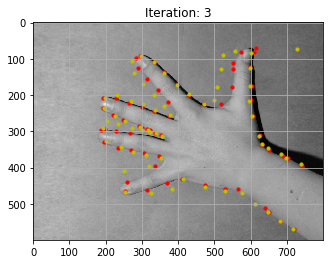

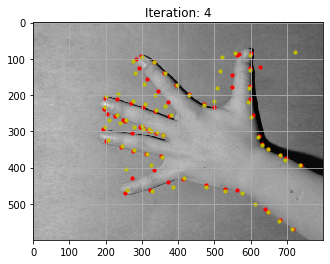

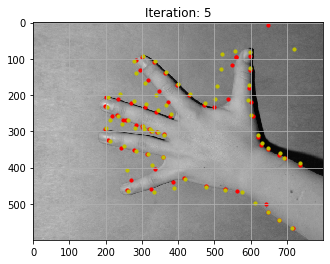

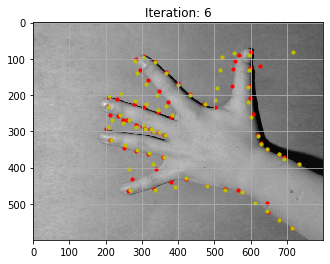

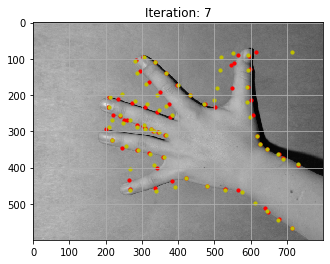

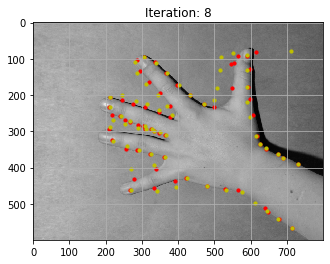

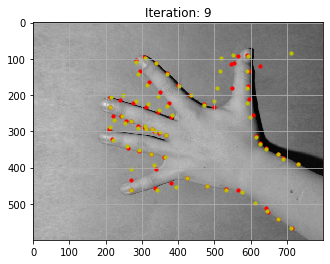

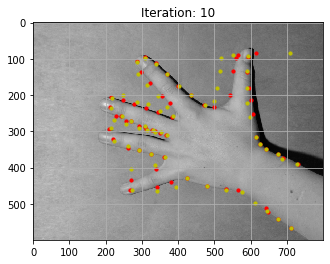

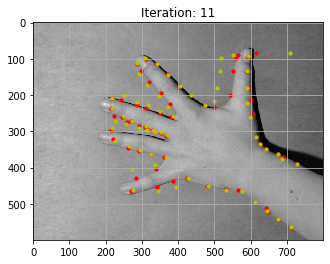

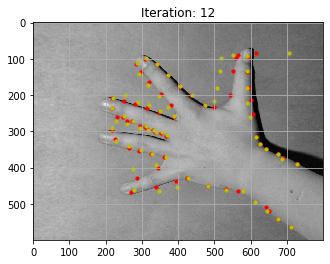

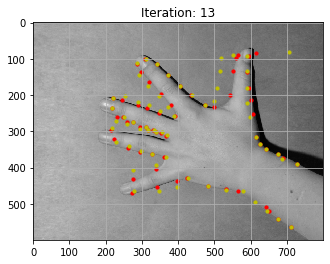

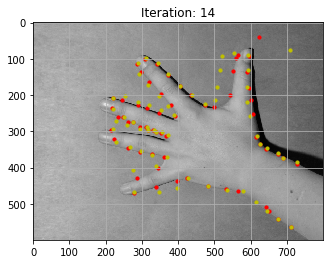

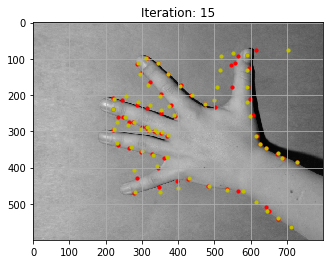

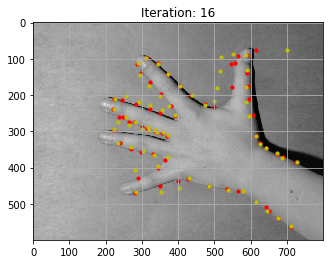

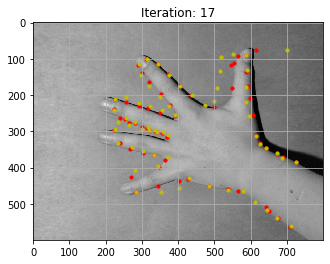

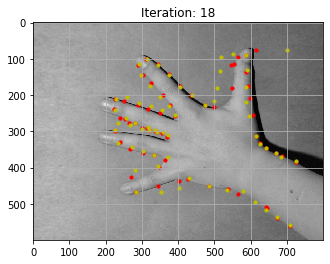

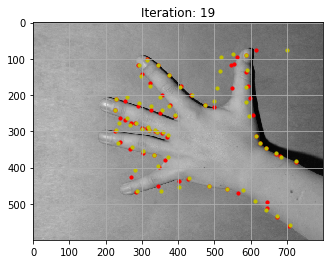

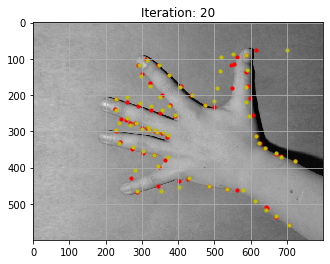

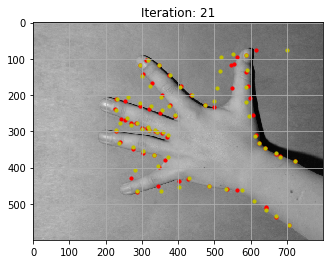

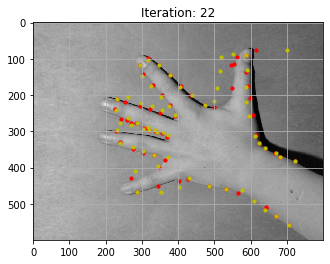

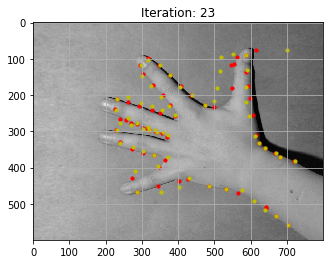

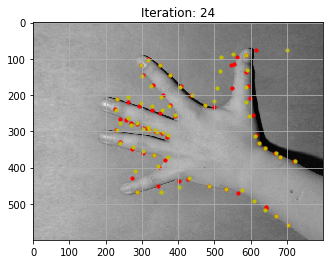

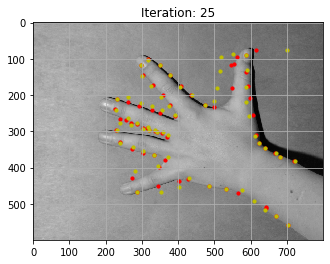

In [6]:
if __name__=='__main__':
    with open("data/hand_landmarks.txt", "r") as file:
        raw_data = [tuple(map(int, line[1:-2].split(','))) for line in file]
    landmarks_data = np.array(raw_data).T
    landmarks = np.column_stack([landmarks_data[1], landmarks_data[0]])
    correspondence = ICP(image, landmarks)
    new_landmarks = correspondence.run_ICP()